# 1. Choose a dataset (TF datasets or some of your own choice, NOT Keras datasets).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, BatchNormalization, Dropout

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.7.0


In [3]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adroit_hammer',
 'd4rl_adroit_pen',
 'd4rl_adroit_relocate',
 'd4rl_mujoco_ant',
 'd4

In [143]:
(test_ds, validate_ds, train_ds), metadata = tfds.load(
'malaria',
split=['train[:15%]', 'train[15%:30%]', 'train[30%:100%]'],
with_info=True,
as_supervised=True)
#print(len(test_ds))
#print(len(validate_ds))
#print(len(train_ds))

# 2. Choose a CNN model. Use a pretrained model from TF Hub or Keras applications (or some other, should you find one). I'd recommend EfficientNet (B0 or B1), but feel free to choose.

In [30]:
# Create the base model from the pre-trained model EfficientNet B1
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224,224,3), 
    include_top=False,
    weights='imagenet', 
    classes=2, 
    pooling="avg",
)

16719872/16705208 [==============================] - 1s 0us/step


# 3. Implement preprocessing. Your model may work only on images of a certain size, so crop and rescale if needed. Be sure to use the preprocessing operation that comes with the model package - some map pixels to [0,1] and some to [-1,1].


In [236]:
BATCH_SIZE = 64
IMAGE_SIZE = [224, 224]


(train_ds, val_ds, test_ds), metadata = tfds.load(
    'malaria',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

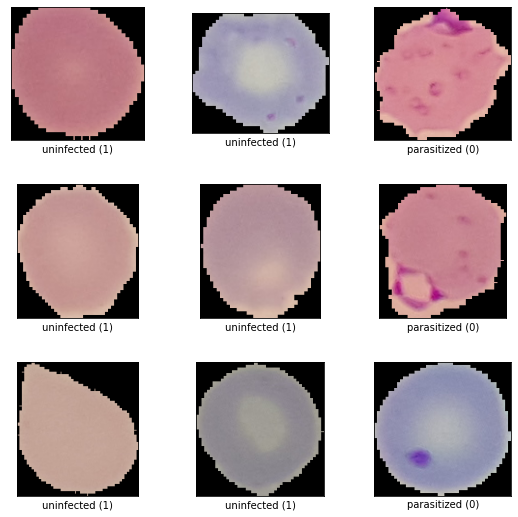

In [237]:
fig = tfds.show_examples(train_ds, metadata)

# 4. Build an input pipeline. Preprocessing should be a part of it. Minibatches should fit into GPU memory.

tf.keras.applications.efficientnet.preprocess_input does nothing. not required. so input pipeline and preprocessing are already part of base model.

# 5. Load only the convolutional base of the pre-trained model and build your own decision part on top of that (e.g. two dense layers + softmax). Sometimes a global averaging of the base model output is needed (some architectures do it as their last step, some don't).

In [32]:
# decision part
def create_decision():
  # create model
  x = base_model.output
  x = BatchNormalization()(x)
  x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
  x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
  x = Dropout(0.1)(x)
  predictions = Dense(1, activation='sigmoid')(x)
  return x, predictions

In [33]:
# create the model

x, predictions = create_decision()
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# print(model.summary())

In [34]:
# freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# model.compile(optimizer='adam', loss='binary_crossentropy')
# print(model.trainable_variables)

# 6. Implement data augmentation. Use the augmentation layers (build own custom ones if you like) and add them between the input layer and the pre-trained model (use the functional API)

In [217]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, Rescaling

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(1, fill_mode="constant"),
])

IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  Resizing(IMG_SIZE, IMG_SIZE),
  #Rescaling(1./255)
])

batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):

  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

# Show some cool examples of cells

In [218]:
get_label_name = metadata.features['label'].int2str

image_iterable = iter(train_ds)

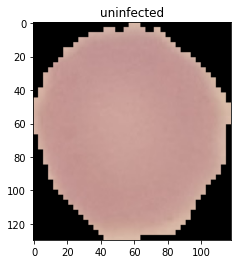

In [232]:
# rerun this cell to get other images

image, label = next(image_iterable)
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

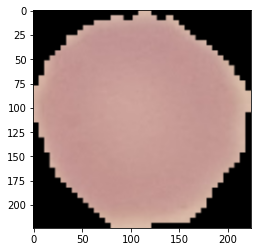

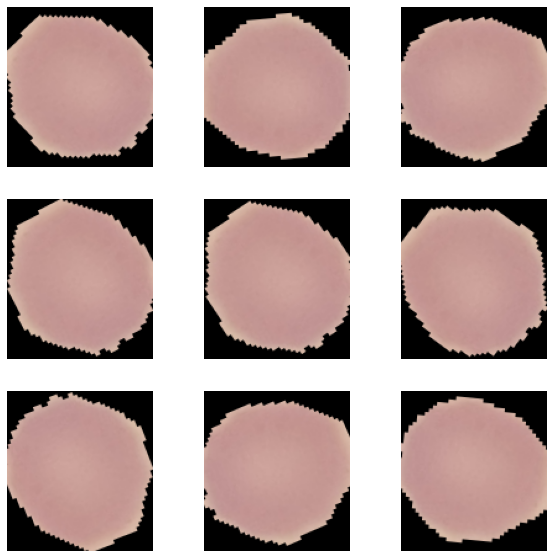

In [233]:
result = resize_and_rescale(image)
_ = plt.imshow(result/255)

# Add the image to a batch.
image = tf.expand_dims(image, 0)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [234]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [17]:
# tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [54]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy())

In [41]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

# 7. Establish a baseline: train and validate your model (with an optimizer of your choice). Plot loss and accuracy curves.

In [55]:
checkpoint_path = "models/transfer-net.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), cp_callback]

In [56]:
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=30,
          verbose='auto',
          callbacks=callbacks)

Epoch 1/30
172/173 [============================>.] - ETA: 0s - loss: 3.1546 - binary_accuracy: 0.9351
Epoch 00001: saving model to models/transfer-net.ckpt
173/173 [==============================] - 23s 116ms/step - loss: 3.1506 - binary_accuracy: 0.9351 - val_loss: 0.2645 - val_binary_accuracy: 0.9434
Epoch 2/30
172/173 [============================>.] - ETA: 0s - loss: 0.2296 - binary_accuracy: 0.9440
Epoch 00002: saving model to models/transfer-net.ckpt
173/173 [==============================] - 20s 113ms/step - loss: 0.2298 - binary_accuracy: 0.9438 - val_loss: 0.2269 - val_binary_accuracy: 0.9445
Epoch 3/30
172/173 [============================>.] - ETA: 0s - loss: 0.2196 - binary_accuracy: 0.9467
Epoch 00003: saving model to models/transfer-net.ckpt
173/173 [==============================] - 20s 113ms/step - loss: 0.2197 - binary_accuracy: 0.9467 - val_loss: 0.1995 - val_binary_accuracy: 0.9496
Epoch 4/30
172/173 [============================>.] - ETA: 0s - loss: 0.2088 - binary

In [57]:
model.evaluate(val_ds)

22/22 [==============================] - 2s 84ms/step - loss: 0.1362 - binary_accuracy: 0.9594


[0.1362011730670929, 0.9593613743782043]

# Plot history

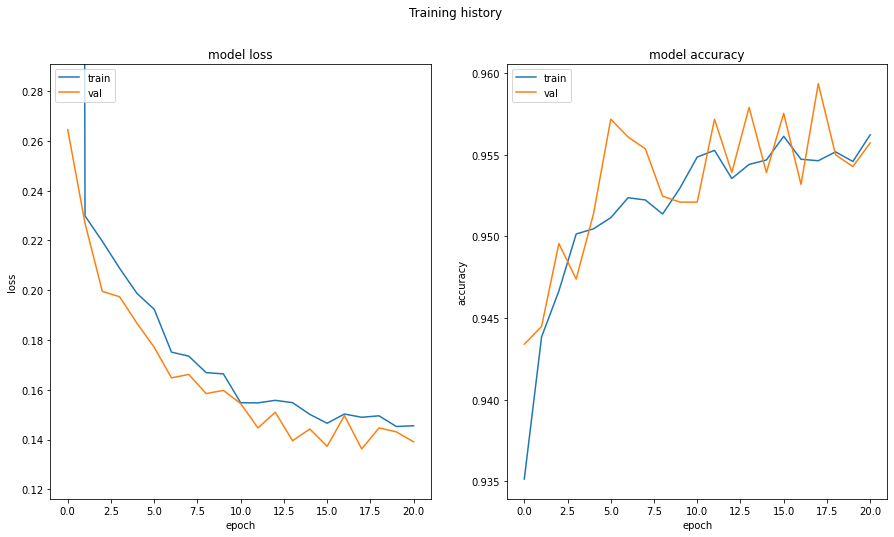

In [60]:
def plot_training_metrics(history):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
  fig.suptitle('Training history')

  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('model loss')
  ax1.set_ylabel('loss')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'val'], loc='upper left')
  ax1.set_ylim(min(history.history['loss'])*0.8, max(history.history['val_loss'])*1.1)

  ax2.plot(history.history['binary_accuracy'])
  ax2.plot(history.history['val_binary_accuracy'])
  ax2.set_title('model accuracy')
  ax2.set_ylabel('accuracy')
  ax2.set_xlabel('epoch')
  ax2.legend(['train', 'val'], loc='upper left')

  plt.show()

plot_training_metrics(history)

# Fine-tuning the model

Fine-tune the model (trained at 7) by opening a few layers (or layer blocks if it's more natural in the model architecture) at a time. Train with a very small learning rate (might take a few tries to find a good starting value). Repeat opening layers until there's no improvement.

In [61]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

44/44 - 3s - loss: 0.1362 - binary_accuracy: 0.9594 - 3s/epoch - 68ms/step
Restored model, validation accuracy: 95.94%
Number of layers in the base model:  238
Number of layers in the decision model:  5
Epoch 21/50
345/345 [==============================] - ETA: 0s - loss: 0.2513 - binary_accuracy: 0.9151
Epoch 00021: saving model to models/transfer-net-finetuned.ckpt
345/345 [==============================] - 100s 276ms/step - loss: 0.2513 - binary_accuracy: 0.9151 - val_loss: 0.1640 - val_binary_accuracy: 0.9532
Epoch 22/50
345/345 [==============================] - ETA: 0s - loss: 0.1641 - binary_accuracy: 0.9518
Epoch 00022: saving model to models/transfer-net-finetuned.ckpt
345/345 [==============================] - 95s 274ms/step - loss: 0.1641 - binary_accuracy: 0.9518 - val_loss: 0.1607 - val_binary_accuracy: 0.9521
Epoch 23/50
345/345 [==============================] - ETA: 0s - loss: 0.1472 - binary_accuracy: 0.9571
Epoch 00023: saving model to models/transfer-net-finetuned.c

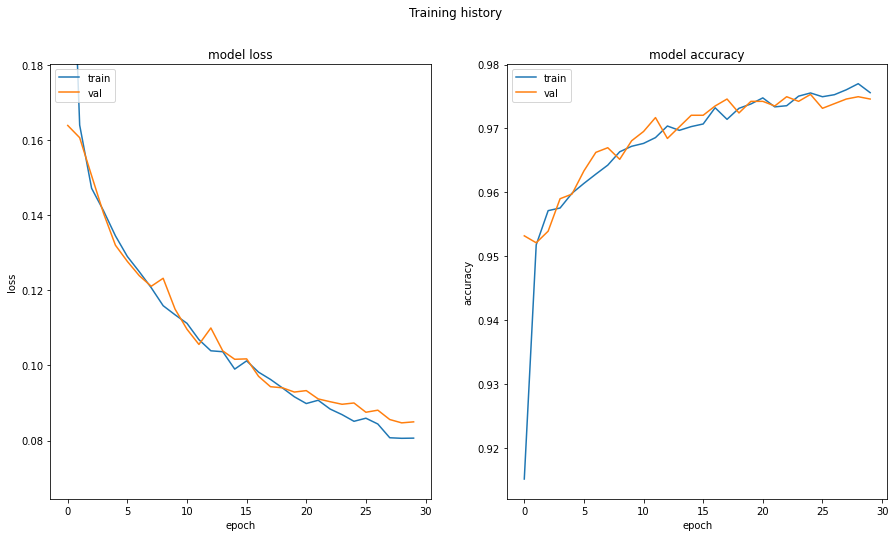

44/44 - 2s - loss: 0.0850 - binary_accuracy: 0.9746 - 2s/epoch - 43ms/step
Fine-tuned model, validation accuracy: 97.46%


In [70]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Restored model, validation accuracy: {:5.2f}%".format(100 * acc))

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the decision model: ", len(model.layers) - len(base_model.layers))

for layer in base_model.layers:
  layer.trainable = False

# freeze the base model layers
for layer in base_model.layers: # Here you could fine tune the model layer by layer, we will try whole model
  print(layer)
  layer.trainable = True

adam = tf.keras.optimizers.Adam(
    learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryAccuracy())

ft_checkpoint_path = "models/transfer-net-finetuned.ckpt"
ft_checkpoint_dir = os.path.dirname(ft_checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), cp_callback]

fine_tune_epochs = 30
total_epochs =  history.epoch[-1] + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine)
# Re-evaluate the model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Fine-tuned model, validation accuracy: {:5.2f}%".format(100 * acc))

## Fine-tune with learning rate scheduler

44/44 - 2s - loss: 0.0850 - binary_accuracy: 0.9746 - 2s/epoch - 40ms/step
Restored model, accuracy: 97.46%
Epoch 50/79
345/345 [==============================] - ETA: 0s - loss: 0.1318 - binary_accuracy: 0.9578
Epoch 00050: saving model to models/transfer-net-finetuned-2.ckpt
345/345 [==============================] - 104s 290ms/step - loss: 0.1318 - binary_accuracy: 0.9578 - val_loss: 0.1082 - val_binary_accuracy: 0.9695 - lr: 0.0010
Epoch 51/79
345/345 [==============================] - ETA: 0s - loss: 0.1059 - binary_accuracy: 0.9639
Epoch 00051: saving model to models/transfer-net-finetuned-2.ckpt
345/345 [==============================] - 98s 283ms/step - loss: 0.1059 - binary_accuracy: 0.9639 - val_loss: 0.1130 - val_binary_accuracy: 0.9626 - lr: 0.0010
Epoch 52/79
345/345 [==============================] - ETA: 0s - loss: 0.1004 - binary_accuracy: 0.9678
Epoch 00052: saving model to models/transfer-net-finetuned-2.ckpt
345/345 [==============================] - 98s 282ms/step -

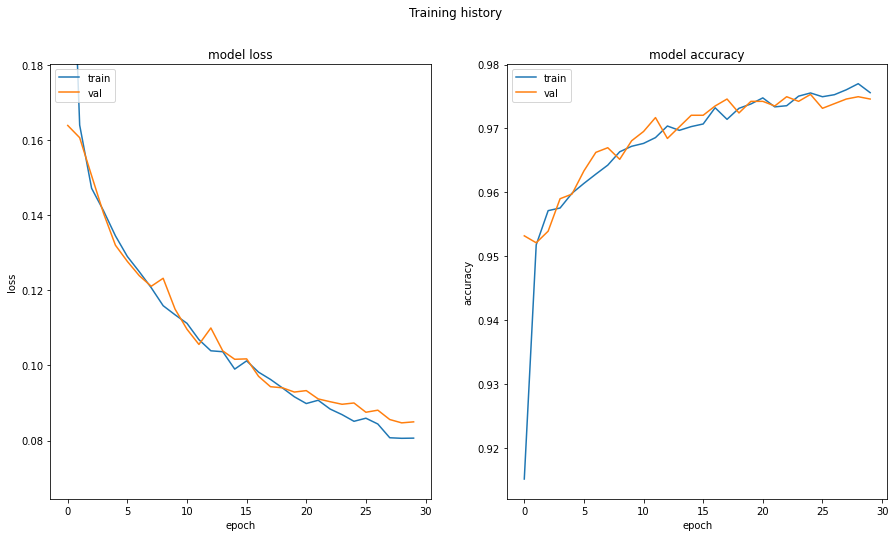

44/44 - 2s - loss: 0.0621 - binary_accuracy: 0.9808 - 2s/epoch - 40ms/step
Fine-tuned model, accuracy: 98.08%


In [97]:
# Exponential decay after certain number of epochs
def scheduler(epoch, lr):
  if epoch < 55:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# Re-freeze all base model layers
for layer in base_model.layers:
  layer.trainable = False

# Open up all layers of the base model
for layer in base_model.layers:
  layer.trainable = True

# Explicitly define optimizer with low learning rate
adam = tf.keras.optimizers.Adam(
    learning_rate=1e-03, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

# Re-compile model
model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryAccuracy())

# Define new path to save weights
ft_checkpoint_path_2 = "models/transfer-net-finetuned-2.ckpt"
ft_checkpoint_dir_2 = os.path.dirname(ft_checkpoint_path_2)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path_2,
                                                 save_weights_only=True,
                                                 verbose=1)
# Define callbacks for training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), cp_callback, lr_callback]

fine_tune_epochs = 30
total_epochs = history_fine.epoch[-1] + fine_tune_epochs

history_fine_2 = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine)
# Re-evaluate the model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Fine-tuned model, accuracy: {:5.2f}%".format(100 * acc))

In [101]:
# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path_2)

# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

44/44 - 2s - loss: 0.0938 - binary_accuracy: 0.9728 - 2s/epoch - 45ms/step
Restored model, accuracy: 97.28%


#### Checkout some examples of erroneously classified images

In [130]:
get_label_name = metadata.features['label'].int2str

image_iterable = iter(test_ds)

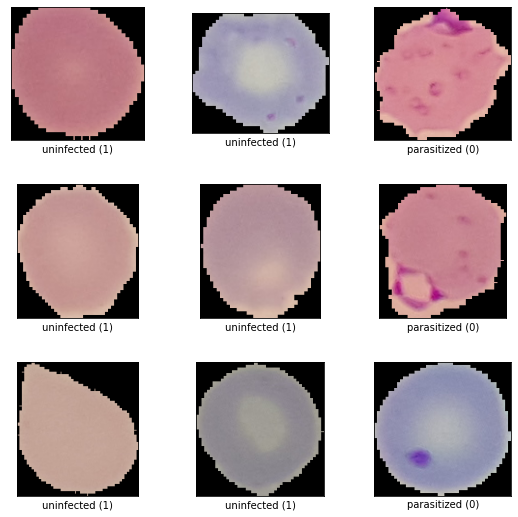

In [148]:
#image, label = next(image_iterable)
#_ = plt.imshow(image)
#_ = plt.title(get_label_name(label))
#predictions = model.predict(image)
#print(predictions[:9])


# Add the image to a batch.
#image = tf.expand_dims(image, 0)




In [154]:
predictions = model.predict(test_ds)
print(len(predictions))

2756


## Examples of erroneous predictions

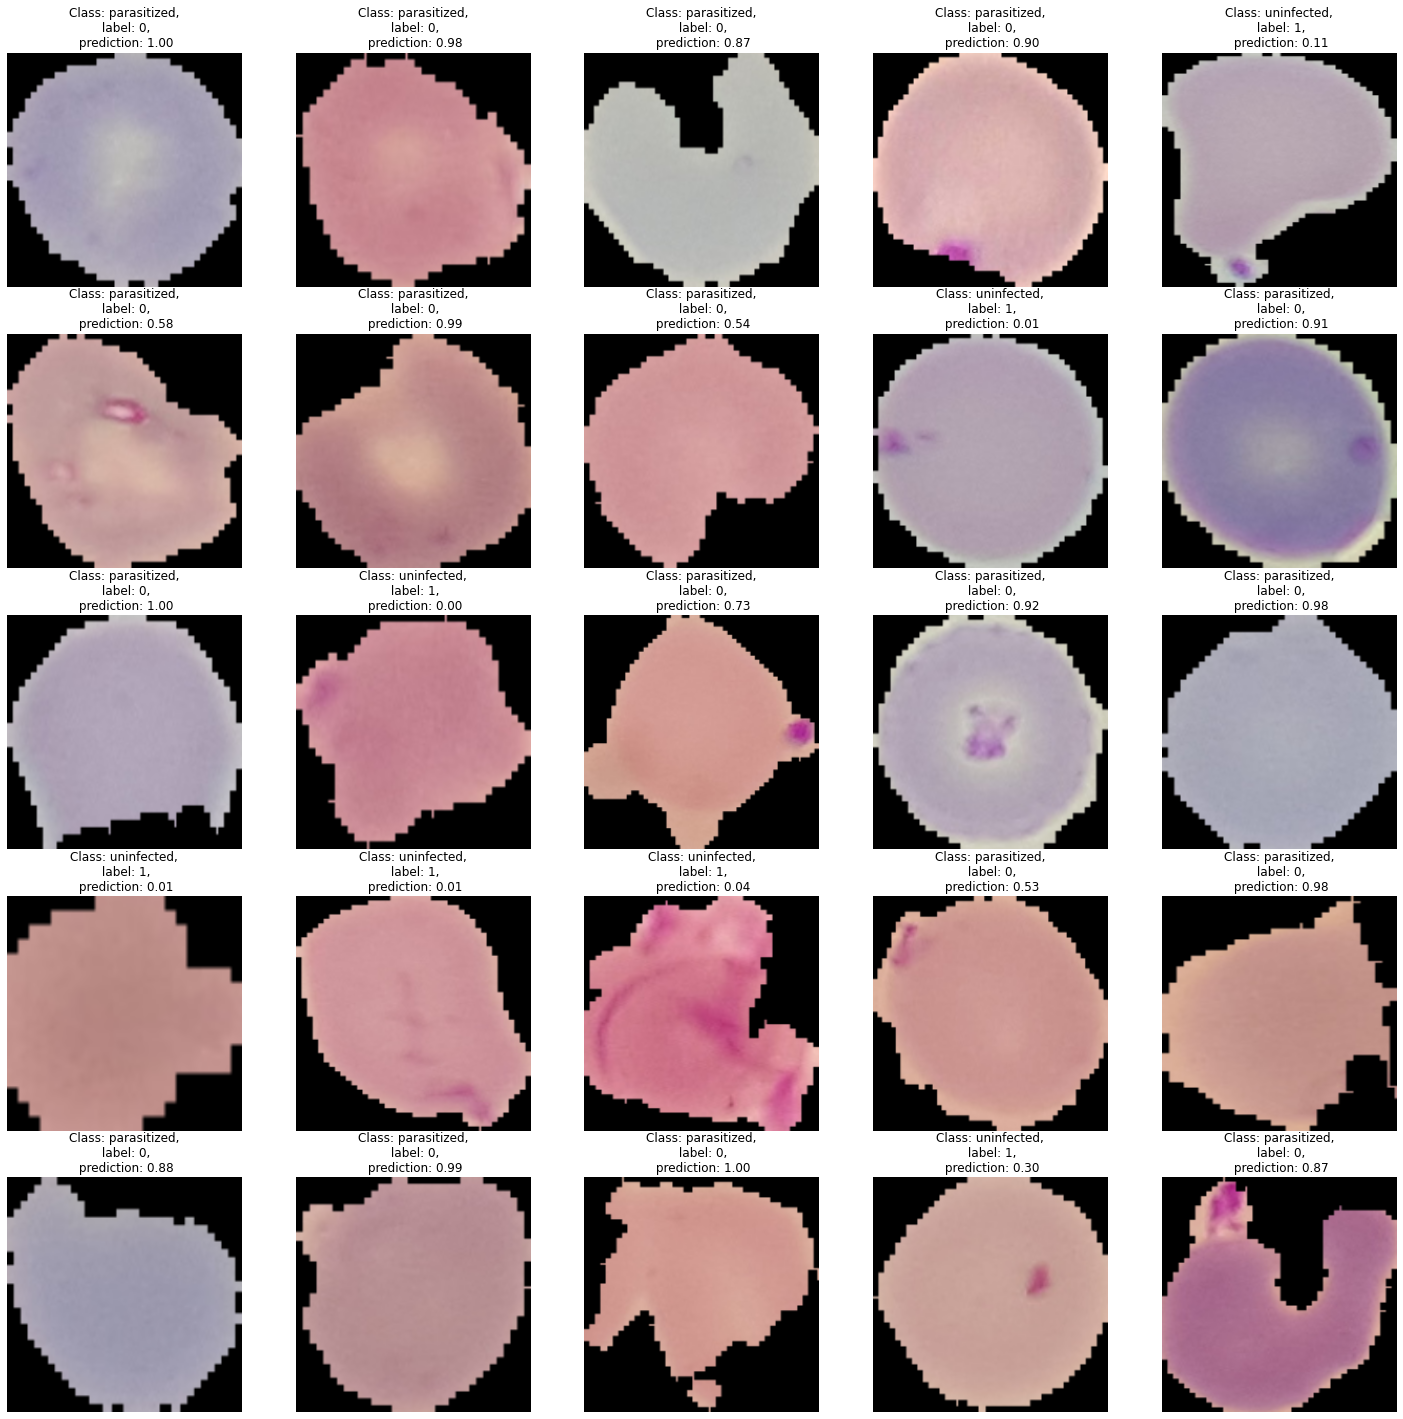

In [211]:
plt.figure(figsize=(25, 25))

false_predictions = 0

for set in test_ds:

    if false_predictions == 25:
      break

    predictions = model.predict(set[0])
    for i in range(len(predictions)):

        label = int(set[1][i])

        if label != round(predictions[i][0]):
          false_predictions += 1
          label_name = get_label_name(label)
          prediction = predictions[i]
          ax = plt.subplot(5, 5, false_predictions)
          plt.imshow(set[0][i]/255)
          plt.axis("off")
          ax.set_title(f'Class: {label_name},\n label: {label},\n prediction: {"%.2f" % prediction[0]}')
          if false_predictions == 25:
            break
plt.show()